In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date, timedelta
from sklearn.cluster import KMeans

https://www.kaggle.com/vanshjatana/analysis-on-coronavirus
이곳을 참조 했습니다.

In [2]:
path = '/kaggle/input/coronavirusdataset/'
patient_data_path = path + 'patient.csv'
route_data_path = path + 'route.csv'
time_data_path = path + 'time.csv'

patient = pd.read_csv(patient_data_path)
route = pd.read_csv(route_data_path)
time = pd.read_csv(time_data_path)

변수확인
1.id the ID of the patient (n-th confirmed patient)
2.sex the sex of the patient
3.birth_year the birth year of the patient
4.country the country of the patient
5.region the region of the patient
6.group the collective infection
7.infection_reason the reason of infection
8.infection_order the order of infection
9.infected_by the ID of who has infected the patient
10.contact_number the number of contacts with people
11.confirmed_date the date of confirmation
12.released_date the date of discharge
13.deceased_date the date of decease
14.state isolated / released / deceased

In [3]:
patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


In [4]:
time.head()

,date,acc_test,acc_negative,acc_confirmed,acc_released,acc_deceased,new_test,new_negative,new_confirmed,new_released,new_deceased
0,2020-01-20,1,0,1,0,0,1,0,1,0,0
1,2020-01-21,1,0,1,0,0,0,0,0,0,0
2,2020-01-22,4,3,1,0,0,3,3,0,0,0
3,2020-01-23,22,21,1,0,0,18,18,0,0,0
4,2020-01-24,27,25,2,0,0,5,4,1,0,0


In [5]:
route.head()

,id,date,province,city,visit,latitude,longitude
0,1,2020-01-19,Incheon,Jung-gu,airport,37.460459,126.440680
1,1,2020-01-20,Incheon,Seo-gu,hospital_isolated,37.478832,126.668558
2,2,2020-01-22,Gyeonggi-do,Gimpo-si,airport,37.562143,126.801884
3,2,2020-01-23,Seoul,Jung-gu,hospital_isolated,37.567454,127.005627
4,3,2020-01-20,Incheon,Jung-gu,airport,37.460459,126.440680


결측치 확인

In [6]:
patient.isna().sum()

id                     0
sex                 5345
birth_year          5358
country                1
region              5357
group               5683
infection_reason    5620
infection_order     5731
infected_by         5696
contact_number      5716
confirmed_date         1
released_date       5728
deceased_date       5743
state                  1
dtype: int64

In [7]:
patient['birth_year'] = patient.birth_year.fillna(0.0).astype(int)
patient['birth_year'] = patient['birth_year'].map(lambda val: val if val > 0 else np.nan)

전처리

In [8]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [9]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days

Accumulated Confirmed Count

In [10]:
patient.confirmed_date = pd.to_datetime(patient.confirmed_date)
daily_count = patient.groupby(patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()

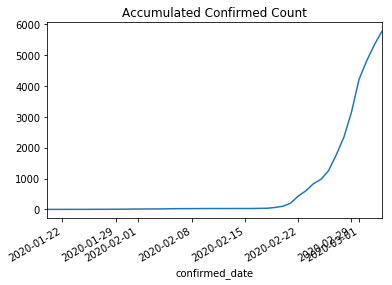

In [11]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

Accumulated Relaesed Count

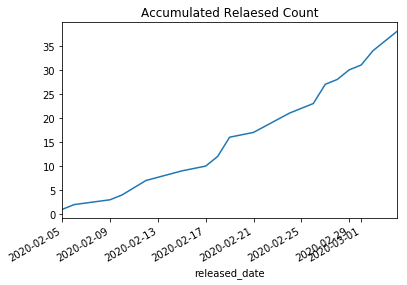

In [12]:
patient.released_date = pd.to_datetime(patient.released_date)
daily_count_released = patient.groupby(patient.released_date).id.count()
accumulated_count_released = daily_count_released.cumsum()
accumulated_count_released.plot()
plt.title('Accumulated Relaesed Count');

Accumulated deceased Count

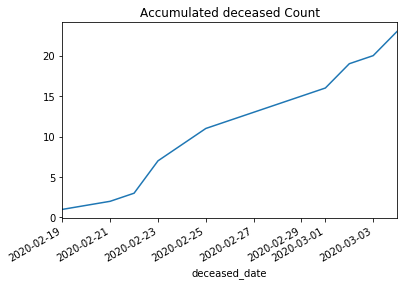

In [13]:
patient.deceased_date = pd.to_datetime(patient.deceased_date)
daily_count_deceased = patient.groupby(patient.deceased_date).id.count()
accumulated_count_deceased = daily_count_deceased.cumsum()
accumulated_count_deceased.plot()
plt.title('Accumulated deceased Count');

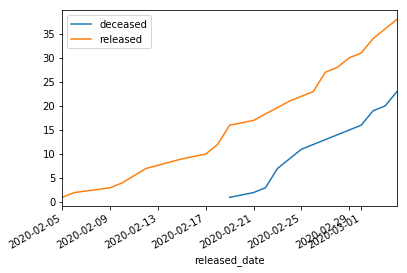

In [14]:
accumulated_count_deceased.plot(label="deceased")
accumulated_count_released.plot(label="released")
plt.legend(loc=2)

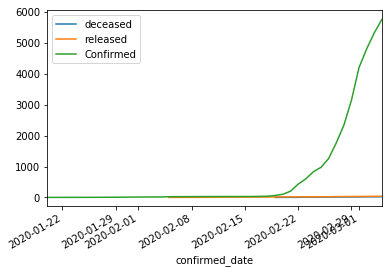

In [15]:
accumulated_count_deceased.plot(label="deceased")
accumulated_count_released.plot(label="released")
accumulated_count.plot(label="Confirmed")
plt.legend(loc=2)

Age distribution of death

In [16]:
patient['age'] = 2020 - patient['birth_year']

In [17]:
dead = patient[patient.state == 'deceased']

In [18]:
dead["age"].describe()


count    23.000000
mean     65.391304
std      12.579706
min      36.000000
25%      58.000000
50%      65.000000
75%      74.500000
max      86.000000
Name: age, dtype: float64

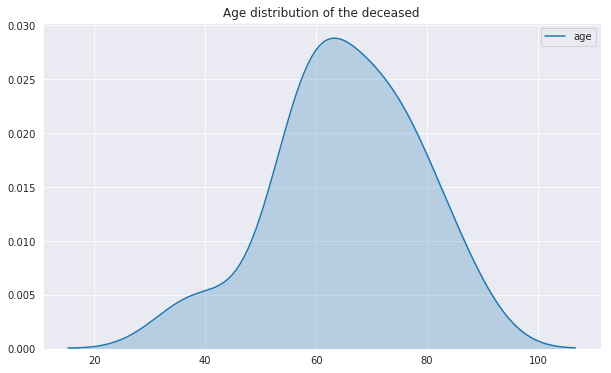

In [19]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the deceased")
sns.kdeplot(data=dead['age'], shade=True)

Age distribution of released

In [20]:
released = patient[patient.state == 'released']

In [21]:
released['age']. describe()

count    40.000000
mean     44.275000
std      14.416848
min      11.000000
25%      35.000000
50%      42.500000
75%      56.000000
max      76.000000
Name: age, dtype: float64

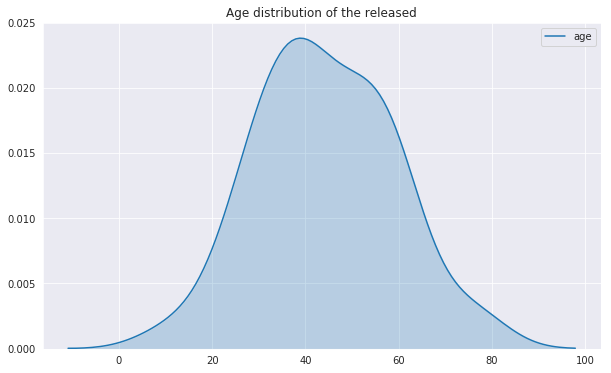

In [22]:
plt.figure(figsize=(10,6))
sns.set_style("darkgrid")
plt.title("Age distribution of the released")
sns.kdeplot(data=released['age'], shade=True)

Comparison of released and deceased by age

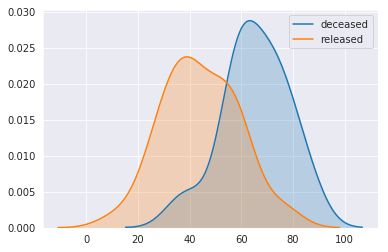

In [23]:
sns.kdeplot(data=dead['age'],label='deceased', shade=True)
sns.kdeplot(data=released['age'],label='released', shade=True)

Age distribution of death by gender

In [24]:
male_dead = dead[dead.sex=='male']
female_dead = dead[dead.sex=='female']

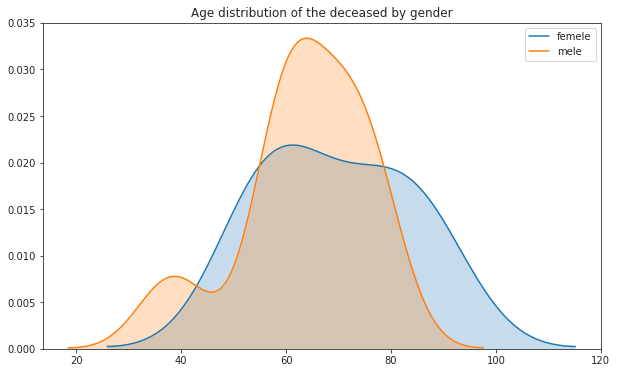

In [25]:
plt.figure(figsize=(10,6))
sns.set_style(("ticks"))
plt.title("Age distribution of the deceased by gender")
sns.kdeplot(data=female_dead['age'],label='femele', shade=True)
sns.kdeplot(data=male_dead['age'],label='mele', shade=True)

Reason for the infection

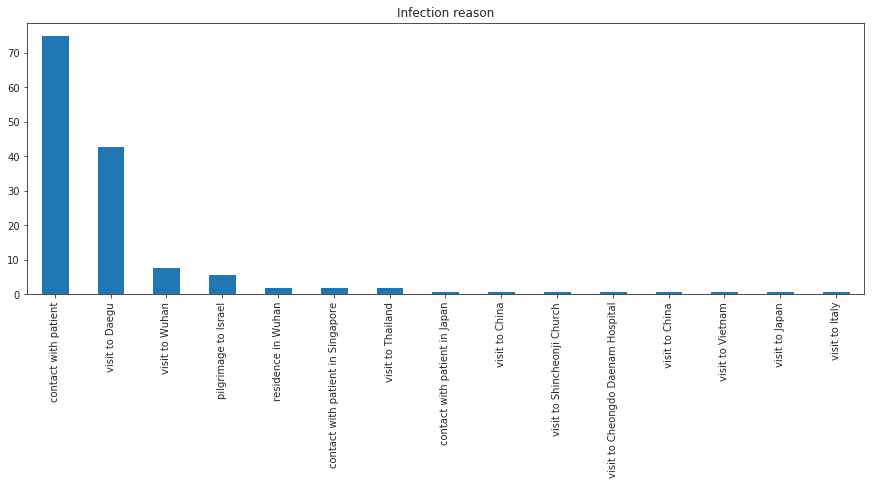

In [26]:
plt.figure(figsize=(15,5))
plt.title('Infection reason')
patient.infection_reason.value_counts().plot.bar()

Patient in province

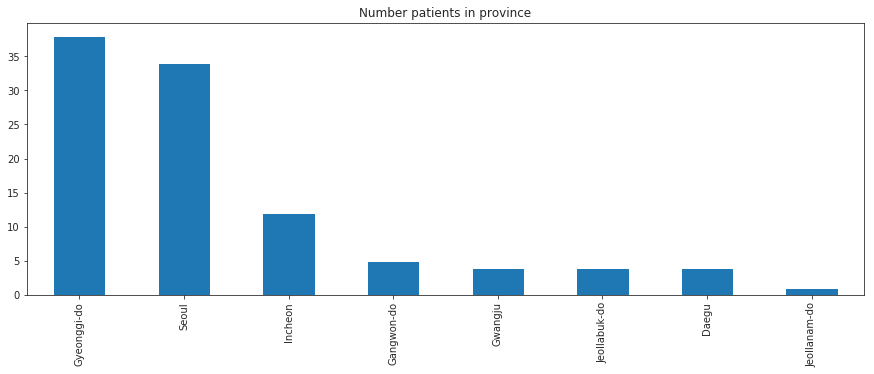

In [27]:
plt.figure(figsize=(15,5))
plt.title('Number patients in province')
route.province.value_counts().plot.bar()

patients in group

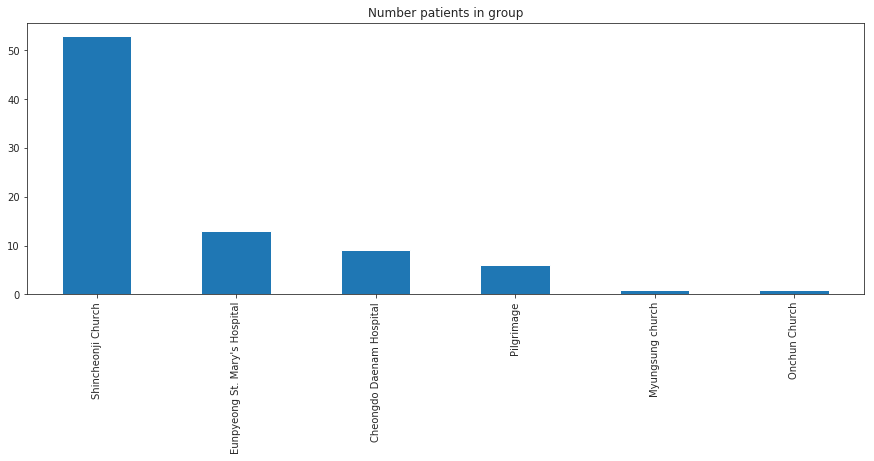

In [28]:
plt.figure(figsize=(15,5))
plt.title('Number patients in group')
patient.group.value_counts().plot.bar()

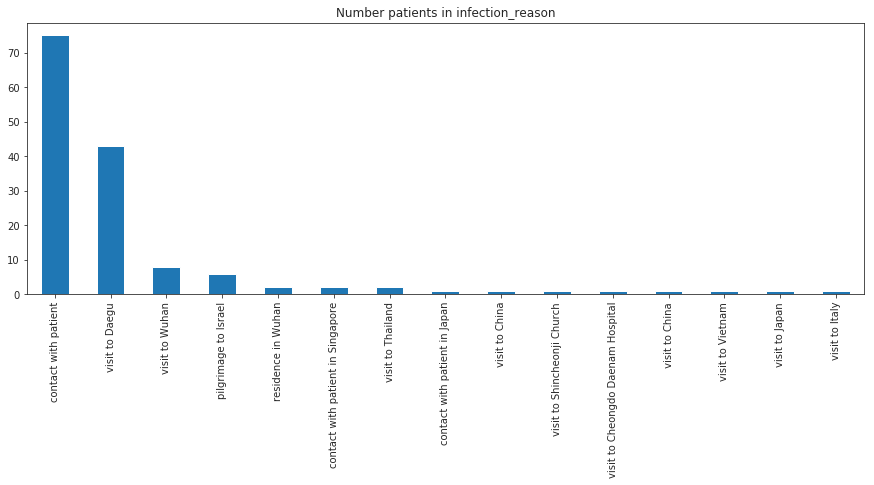

In [29]:
plt.figure(figsize=(15,5))
plt.title('Number patients in infection_reason')
patient.infection_reason.value_counts().plot.bar()

Released by age

Text(0.5, 1.0, 'released by age')

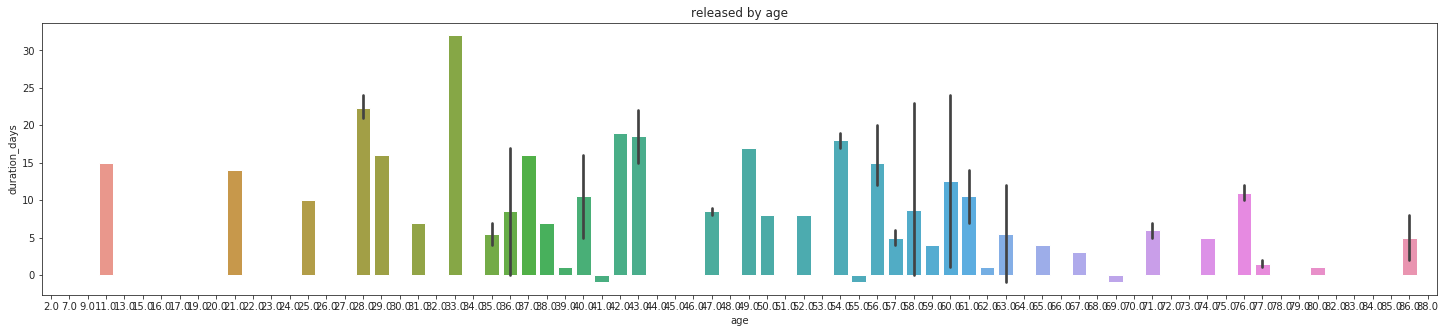

In [30]:
plt.figure(figsize=(25,5))
sns.barplot(
    data= patient,
    x= "age",
    y= "duration_days"
)
plt.title('released by age')